# Exploring Fractals

Exploring different fractals

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm
import threading
import concurrent.futures as conc
from scipy.ndimage.filters import convolve
from colorsys import hls_to_rgb, rgb_to_hls
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['image.cmap'] = 'viridis'

def normalize(array):
    """
    Normalize array to range of 0 to 1
    """
    mn = np.min(array)
    mx = np.max(array)
    return (array - mn)/(mx - mn)


class image_range:
    """
    Helper iterator which loops 
    through each pixel in image
    """
    def __init__(self, size):
        self.I = size[0]
        self.J = size[1]
        self.reset()
        
    def reset(self):
        self.i = 0
        self.j = 0
        
    def __len__(self):
        return self.I*self.J - 1
        
    def __iter__(self):
        self.reset()
        return self
    
    def __next__(self):
        self.j += 1
        if self.j >= self.J:
            self.j = 0
            self.i += 1
            if self.i >= self.I:
                raise StopIteration()
        return self.i, self.j

C:\Users\Anshul Kharbanda\AppData\Local\Temp\ipykernel_14884\152117730.py:7: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


## Julia/Mandelbrot Set

Use the following iteration function:

$$
z_{n+1} = z_n^2 + c
$$

In [2]:
def mandelbrot(z, c):
    return z*z + c

The we could set the initial $z$ parameter for each pixel and fix $c$ as a constant ("julia set" fractal, what I'm calling it) 

Generating:   0%|          | 0/239999 [00:00<?, ?it/s]

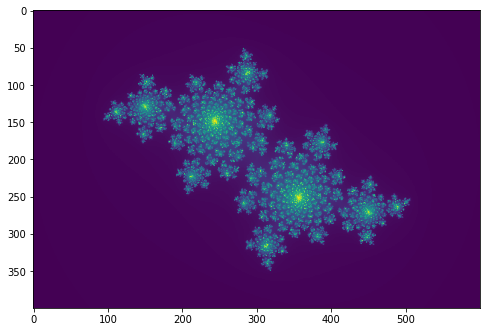

CPU times: total: 1.88 s
Wall time: 1.9 s


In [3]:
%%time

# Algorithm parameters
size = 600, 400
iterations = 255
c = -0.4 - 0.6j

# Image array
image = np.zeros((size[1], size[0]), dtype=np.uint8)

# Run algorithm on each pixel in image
for i, j in tqdm(image_range(size), desc='Generating'):
    z = complex(i - size[0]/2, j - size[1]/2)/max(size)*4
    n = 0
    while abs(z) < 2 and n < iterations:
        z = mandelbrot(z, c)
        n += 1
    image[j, i] = n

# Display image
plt.imshow(image)
plt.show();

Or we could set the $c$ constant and start at $z = 0$ for each pixel (mandelbrot set)

Generating:   0%|          | 0/239999 [00:00<?, ?it/s]

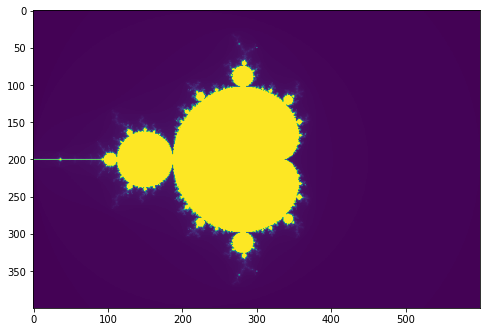

CPU times: total: 4.33 s
Wall time: 4.34 s


In [4]:
%%time

# Algorithm parameters
size = 600, 400
iterations = 255

# Image array
image = np.zeros((size[1], size[0]), dtype=np.uint8)

# Run algorithm on each pixel in image
for i, j in tqdm(image_range(size), desc='Generating'):
    c = complex(i - size[0]/2, j - size[1]/2)/max(size)*4
    z = 0
    n = 0
    while abs(z) < 2 and n < iterations:
        z = mandelbrot(z, c)
        n += 1
    image[j, i] = n
        
# Display image
plt.imshow(image)
plt.show();

## Burning Ship Fractal

Same general algorithm as Mandelbrot set, but a slight tweak to the formula:

$$
z_{n+1} = (|\Re(z_i)| + i|\Im(z_i)|)^2 + c
$$

Each part of the z value is set to their respective absolute values.

In [5]:
def burning_ship(z, c):
    za = complex(abs(z.real), abs(z.imag))
    return za*za + c

Juliaset fractal

Generating:   0%|          | 0/239999 [00:00<?, ?it/s]

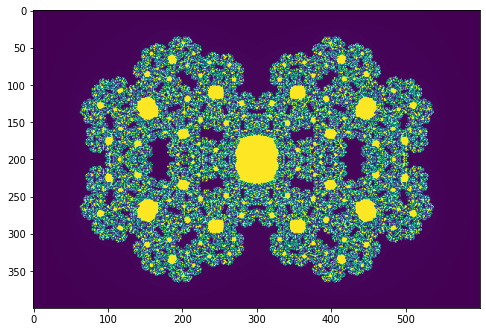

CPU times: total: 10.7 s
Wall time: 10.7 s


In [6]:
%%time

# Algorithm parameters
size = 600, 400
iterations = 255
c = -0.75 - 0.90j

# Image array
image = np.zeros((size[1], size[0]), dtype=np.uint8)

# Run algorithm on each pixel in image
for i, j in tqdm(image_range(size), desc='Generating'):
    z = complex(i - size[0]/2, j - size[1]/2)/max(size)*4
    n = 0
    while abs(z) < 2 and n < iterations:
        z = burning_ship(z, c)
        n += 1
    image[j, i] = n

# Display image
plt.imshow(image)
plt.show();

And mandelbrot fractal

Generating:   0%|          | 0/239999 [00:00<?, ?it/s]

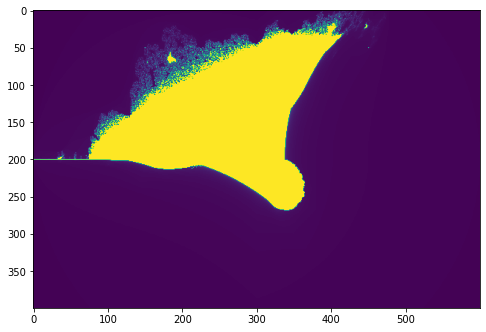

CPU times: total: 8.58 s
Wall time: 8.55 s


In [7]:
%%time

# Algorithm parameters
size = 600, 400
iterations = 255

# Image array
image = np.zeros((size[1], size[0]), dtype=np.uint8)

# Run algorithm on each pixel in image
for i, j in tqdm(image_range(size), desc='Generating'):
    c = complex(i - size[0]/2, j - size[1]/2)/max(size)*4
    z = 0
    n = 0
    while abs(z) < 2 and n < iterations:
        z = burning_ship(z, c)
        n += 1
    image[j, i] = n
        
# Display image
plt.imshow(image)
plt.show();

## Polynomial Roots Fractal Using Newton's method

Define complex polynomial function $f(z)$ and find roots of function using Newton's method

$$
z_{n+1} = z_n - \frac{f(z_n)}{f'(z_n)}
$$

We can define the function based on the roots

$$
f(z) = (z - r_1)(z - r_2)(z - r_3) = \prod_{i=1}^D{z - r_i}
$$

$D$ is the degree of the polynomial

We can use the product rule to differentiate in this form. The product rule has a useful symmetry that we can exploit

$$
(p r q)' = p'rq + p r'q + p r q' + ...
$$

Since $p$, $q$, and $r$ all take the form of $z - c$ (where $c$ is a constant), each of their individual derivatives reduces to $1$. So we can rewrite the derivative as follows

$$
f'(z) = (z - r_2)(z - r_3) + (z - r_1)(z - r_3) + (z - r_2)(z - r_3)
$$

More generally we could construct this formula

$$
f'(z) = \sum_{i=1}^D{ \prod_{j \neq i}{z - r_j} }
$$

In numpy, we're representing a polynomial by an array of roots. 

```
r = np.array([ r1, r2, r3, ... ])
```

The output of the polynomial given a `z` input is written as 

```
(z - r).prod()
```

The derivative is a bit trickier. Since we have two aggregate functions, we could start with a meshgrid array of the terms in `z - r`

```
d = r.shape[0]
p = z - r
pp = np.meshgrid(p, p)[0]
```

$$
\text{pp} = \begin{bmatrix}
z - r_1 & z - r_2 & z - r_3 & ... \\
z - r_1 & z - r_2 & z - r_3 & ... \\
z - r_1 & z - r_2 & z - r_3 & ... \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}
$$

The final derivative is a sum of a product. Looking at the formula above, we note that each product must contain only terms where $i \neq j$, which means no terms on the diagonals. So, we multiply our terms using a sort of "opposite" identity matrix to filter everything off the diagonal

$$
(1 - \text{I}) = \begin{bmatrix}
0 & 1 & 1 & ... \\
1 & 0 & 1 & ... \\
1 & 1 & 0 & ... \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}
$$

```
pp *= (1 - np.eye(d))
```

$$
\text{pp} = \begin{bmatrix}
0 & z - r_2 & z - r_3 & ... \\
z - r_1 & 0 & z - r_3 & ... \\
z - r_1 & z - r_2 & 0 & ... \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}
$$

Since we're doing a product, there shouldn't be zero terms, since that will cause all terms to go to $0$. So we replace the zero terms along the diagonal with $1$ by adding another identity matrix

```
pp += np.eye(d)
```

$$
\text{pp} = \begin{bmatrix}
1 & z - r_2 & z - r_3 & ... \\
z - r_1 & 1 & z - r_3 & ... \\
z - r_1 & z - r_2 & 1 & ... \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}
$$

We can then take a product across the rows and finally sum the resulting terms, giving us the final derivative formula.

```
pp.prod(axis=1).sum()
```

In [8]:
%%time

def newtons_method(z, r):
    """
    Iterate z through one step of newton's method
    
    :param z: argument (being updated towards 0)
    :param r: polynomial roots array
    """
    d = r.shape[0] # Dimension of array
    p = z - r # Polynomial product terms array
    pp = np.meshgrid(p, p)[0] * (1 - np.eye(d)) + np.eye(d) # Derivative terms matrix
    return z - p.prod()/pp.prod(axis=1).sum() # New value of z from Newton's method

# Return index of root nearest to z given array of roots r
arg_nearest_root = lambda z, r: np.argmin(np.abs(z - r))


# Test with following roots
roots = np.array([ 1, np.sqrt(2)*(-1 + 1j), np.sqrt(2)*(-1 - 1j) ])
seeds = [ 0, 1, -1, 0.25j, -2j, 2j, -10 ]
final = []
for seed in seeds:
    z = seed
    for i in range(256):
        z = newtons_method(z, roots)
    final.append(z)
    
print('Seed', 'Final', sep='\t')
for seed, fina in zip(seeds, final):
    print(seed, fina, sep='\t')
print()

Seed	Final
0	(1+0j)
1	(1+0j)
-1	(1+0j)
0.25j	(1+0j)
(-0-2j)	(-1.4142135623730951-1.4142135623730951j)
2j	(-1.4142135623730951+1.4142135623730951j)
-10	(1+0j)

CPU times: total: 109 ms
Wall time: 112 ms


If we run the iteration for a grid of complex numbers and color them based on the root that they landed on. We can see a fractal pattern emerge.

Note: This particular fractal is very expensive to run, so it's being run multithreaded

In [9]:
%%script false --no-raise-error
%%time

# Parameters
size = 600, 400
iterations = 16
thread_count = 12

# Image buffer
image = np.zeros((size[1], size[0]), dtype=np.uint8)

# Polynomial from complex roots
roots = np.array([ 1, np.sqrt(2)*(-1 + 1j), np.sqrt(2)*(-1 - 1j) ])

# Progress bar
progress_lock = threading.Lock()
progress = tqdm(total=size[0]*size[1] - 1, desc='Generating')

def thread_worker(pixel):
    """
    Run newton's method for given pixel coordinates
    Set image result to the nearest root that parameter lands on
    """
    global image
    i, j = pixel
    z = complex(i - size[0]/2, j - size[1]/2)/max(size)*4
    for _ in range(iterations):
        z = newtons_method(z, roots)
    image[j, i] = arg_nearest_root(z, roots)
    with progress_lock:
        progress.update()
        
# Map image iterations using thread pool executor
with conc.ThreadPoolExecutor(max_workers=thread_count) as exe:
    exe.map(thread_worker, image_range(size))
with progress_lock:
    progress.close()
    
# Show image
image = np.linspace(0, 1, roots.shape[0])[image]
plt.imshow(image);
plt.show();

Couldn't find program: 'false'


## Fractal Shadow Calculation

I've seen many fractal renders with shadows and I wanted to try my hand at doing that. So I'm experimenting with how to do proper shadow calculations

Generating:   0%|          | 0/239999 [00:00<?, ?it/s]

Convolving kernel...
Mapping color...
Plotting...


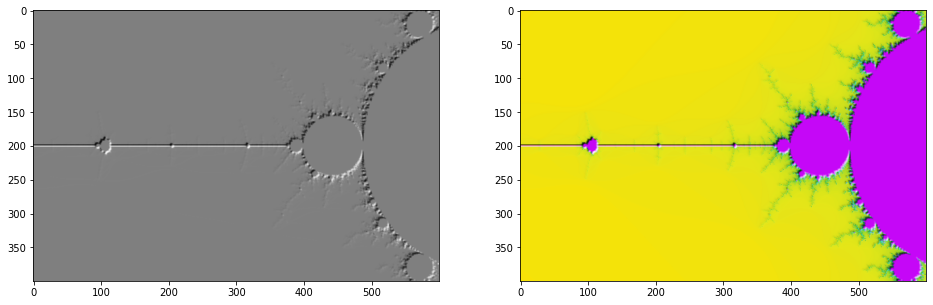

CPU times: total: 17.2 s
Wall time: 17 s


In [10]:
%%time
plt.rcParams['figure.figsize'] = [16, 12]

# Algorithm parameters
size = 600, 400
iterations = 255
thread_count = 12
zoom = 5
translate = -1.5
shadow_kernel_width = 4

def map_over_pixel(func, image):
    """
    Helper function for converting over pixel space
    """
    return np.array([
        [ list(func(*pixel)) for pixel in row ]
        for row in image
    ])

# Image array
fractal = np.zeros((size[1], size[0]), dtype=np.uint8)

# Progress bar
progress_lock = threading.Lock()
progress = tqdm(total=size[0]*size[1] - 1, desc='Generating')

def thread_worker(pixel):
    """
    Run mandelbrot for given pixel's complex parameter
    """
    global image
    i, j = pixel
    c = complex(i - size[0]/2, j - size[1]/2)/max(size)*4
    c /= zoom
    c += translate
    z = 0
    n = 0
    while abs(z) < 2 and n < iterations:
        z = mandelbrot(z, c)
        n += 1
    fractal[j, i] = n
    with progress_lock:
        progress.update()
        
# Map image iterations using thread pool executor
with conc.ThreadPoolExecutor(max_workers=thread_count) as exe:
    exe.map(thread_worker, image_range(size))
with progress_lock:
    progress.close()
fractal = fractal.astype(np.float32) / 256
    
# Convolve shadow kernel over image
print('Convolving kernel...')
kx,ky = np.meshgrid(
    np.arange(float(shadow_kernel_width) - 1.0, -1.0, -1.0), 
    np.arange(0,float(shadow_kernel_width)))
kernel = ky - kx
kernel /= np.sum(np.abs(kernel))
lightmap = convolve(fractal, kernel)

# Combine fractal and shadow information to color
# Param space -> cmap space -> hls space -> set luminance to shadow -> rgb space
print('Mapping color...')
cmapimage = cm.get_cmap('viridis', 256)(1 - fractal)
cmapimage = cmapimage[:,:,:3]
hlsimage = map_over_pixel(rgb_to_hls, cmapimage)
hlsimage[:,:,1] = normalize(lightmap)
rgbimage = map_over_pixel(hls_to_rgb, hlsimage)

# Display final image and shadow map
print('Plotting...')
fig = plt.figure();
plt.subplot(1,2,1);
plt.imshow(lightmap, cmap='gray');
plt.subplot(1,2,2);
plt.imshow(rgbimage);
plt.show();

## My Own Fractals

I'm going to be running the mandelbrot algorithm on various generator functions

In [11]:
def generate_fractal(function, size, iterations, id_='Fractal'):
    # Image array
    image = np.zeros((size[1], size[0]), dtype=np.uint8)

    # Run algorithm on each pixel in image
    for i, j in tqdm(image_range(size), desc=('Generating ' + id_)):
        c = complex(i - size[0]/2, j - size[1]/2)/max(size)*4
        z = 0
        n = 0
        while abs(z) < 2 and n < iterations:
            z = function(z, c)
            n += 1
        image[j, i] = n
        
    # Return image
    return image

Equations to Test:

$$
z = z^3 + c
$$

$$
z = |z|^2 + c
$$

$$
z = z*(z + c)
$$

Generating z**3 + c:   0%|          | 0/239999 [00:00<?, ?it/s]

Generating abs(z)**2 + c:   0%|          | 0/239999 [00:00<?, ?it/s]

Generating z*(z + c):   0%|          | 0/239999 [00:00<?, ?it/s]

Plotting...


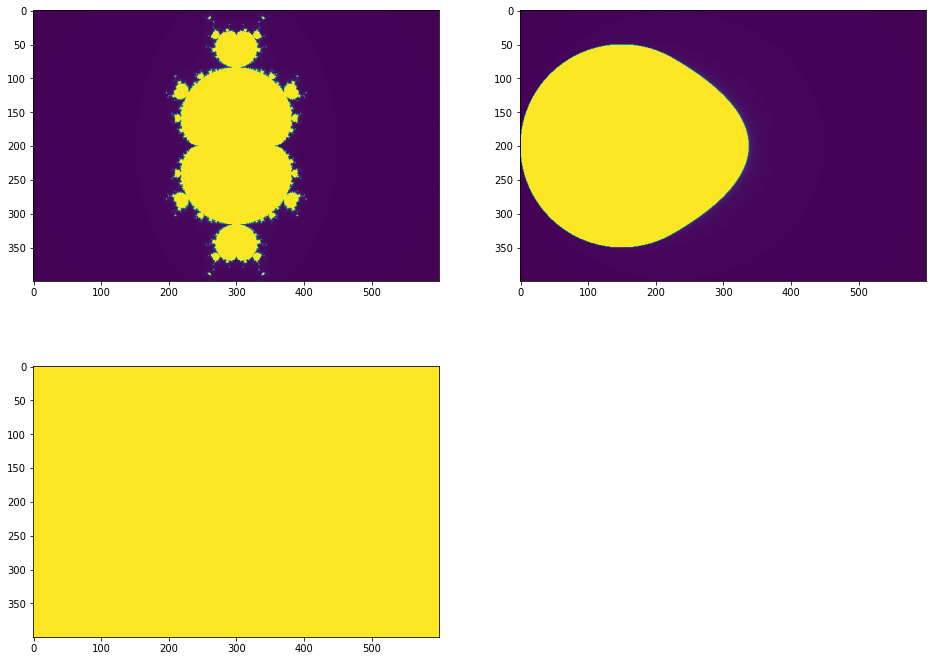

CPU times: total: 2min 4s
Wall time: 2min 4s


In [12]:
%%time
plt.rcParams['figure.figsize'] = [16, 12]

# Params
size = 600, 400
iterations = 255

# Generate fractals
image_1 = generate_fractal(lambda z, c: z**3 + c, size, iterations, id_='z**3 + c')
image_2 = generate_fractal(lambda z, c: np.abs(z)**2 + c, size, iterations, id_='abs(z)**2 + c')
image_3 = generate_fractal(lambda z, c: z*(z + c), size, iterations, id_='z*(z + c)')

# Plot them
print('Plotting...')
plt.subplot(2,2,1)
plt.imshow(image_1)
plt.subplot(2,2,2)
plt.imshow(image_2)
plt.subplot(2,2,3)
plt.imshow(image_3)
plt.show()